# Hyde
HyDE（Hypothetical Document Embeddings：仮の文書の埋め込み）は、入力されたクエリに対して仮の文書を生成し、その文書を埋め込み、検索に使用する手法です。

典型的な文書検索では、ユーザーが入力したクエリと文書の類似度を計算することが多いですが、クエリと文書が必ずしも類似しているとは限りません。そのため、生成モデルを使って回答のような文書（Hypothetical Document）を生成し、その文書と検索エンジンに格納された文書の類似度を計算してしまおうという考え方です。



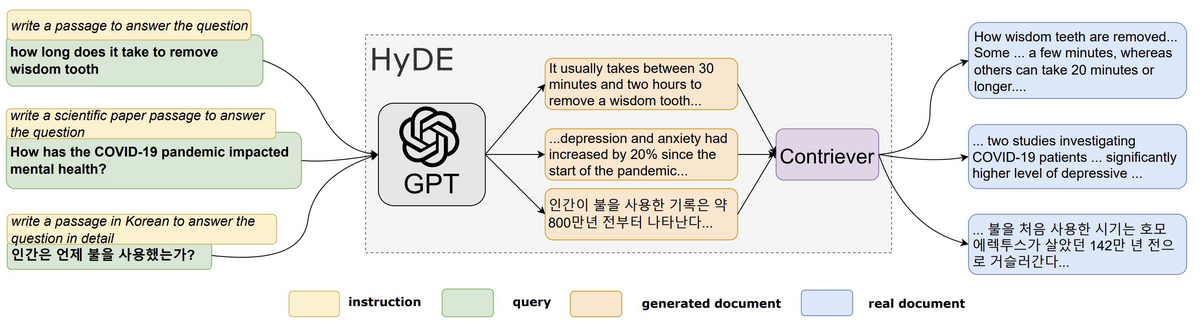

# 下準備

In [7]:
from langchain_community.document_loaders import DirectoryLoader
from langchain.text_splitter import MarkdownHeaderTextSplitter,RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.prompts import PromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.chains import LLMChain

#Document load
loader = DirectoryLoader("../datasets/company_documents_dataset_1/", glob="**/*.txt",recursive=True)
raw_docs = loader.load()

# Document split
headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
]
markdown_splitter = MarkdownHeaderTextSplitter(
    headers_to_split_on=headers_to_split_on, 
    return_each_line=False,
    strip_headers = False 
)
docs = []
for raw_doc in raw_docs:
    source = raw_doc.metadata["source"]
    spilited_docs = markdown_splitter.split_text(raw_doc.page_content)
    for doc in spilited_docs:
        doc.metadata["source"] = source#metadataにsourceを加える
    docs = docs + spilited_docs
markdown_splited_docs = docs
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 300,chunk_overlap=50)
docs = text_splitter.split_documents(docs)

# Embd
vectorstore = Chroma.from_documents(persist_directory="./vecstore/index", documents=docs, embedding=OpenAIEmbeddings())

#llm
llm = ChatOpenAI(model_name="gpt-3.5-turbo",temperature=0)

# retriever
retriever = vectorstore.as_retriever(search_kwargs={"k": 4})



/Users/rokuroyamaki/anaconda3/envs/llm/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.embeddings.openai.OpenAIEmbeddings` was deprecated in langchain-community 0.1.0 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(
/Users/rokuroyamaki/anaconda3/envs/llm/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.chat_models.openai.ChatOpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecat

# Hyde Prompt

In [5]:
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from langchain.prompts.prompt import PromptTemplate

hyde_template = """Please write a japanese sentence to answer the question
Question: {question}
Passage:"""
prompt_hyde = PromptTemplate.from_template(hyde_template)

hyde_chain = (
    prompt_hyde | ChatOpenAI(temperature=0) | StrOutputParser() 
)

# Run
question = "社長の名前は？"
hyde_chain.invoke({"question":question})

'社長の名前は山田さんです。'

# Retriever

In [8]:
retrieval_chain = hyde_chain | retriever 
retireved_docs = retrieval_chain.invoke({"question":question})
retireved_docs

[Document(page_content='### 社長  \n漆黒 花太郎（しっこく かたろう）', metadata={'Header 1': '株式会社架空ブラック 会社情報', 'Header 2': '会社概要', 'Header 3': '社長', 'source': '../datasets/company_documents_dataset_1/マニュアル/会社情報.txt'}),
 Document(page_content='### 社長  \n漆黒 花太郎（しっこく かたろう）', metadata={'Header 1': '株式会社架空ブラック 会社情報', 'Header 2': '会社概要', 'Header 3': '社長', 'source': '../datasets/company_documents_dataset_1/マニュアル/会社情報.txt'}),
 Document(page_content='### 社長  \n漆黒 花太郎（しっこく かたろう）', metadata={'Header 1': '株式会社架空ブラック 会社情報', 'Header 2': '会社概要', 'Header 3': '社長', 'source': '../datasets/company_documents_dataset_1/マニュアル/会社情報.txt'}),
 Document(page_content='## 社長のプロフィール  \n### 名前  \n漆黒 花太郎（しっこく かたろう）', metadata={'Header 1': '株式会社架空ブラック 会社情報', 'Header 2': '社長のプロフィール', 'Header 3': '名前', 'source': '../datasets/company_documents_dataset_1/マニュアル/会社情報.txt'})]

# RAG

In [17]:
from langchain.prompts import ChatPromptTemplate
from langchain.callbacks.tracers import ConsoleCallbackHandler
rag_template = """Answer the following question based on this context:

{context}

Question: {question}
"""

rag_prompt = ChatPromptTemplate.from_template(rag_template)

rag_chain = (
    rag_prompt
    | llm
    | StrOutputParser()
)
handler = ConsoleCallbackHandler()

rag_chain.invoke({"context":retireved_docs,"question":question},{"callbacks":[handler]})


[chain/start] [1:chain:RunnableSequence] Entering Chain run with input:
[inputs]
[chain/start] [1:chain:RunnableSequence > 2:prompt:ChatPromptTemplate] Entering Prompt run with input:
[inputs]
[chain/end] [1:chain:RunnableSequence > 2:prompt:ChatPromptTemplate] s] Exiting Prompt run with output:
{
  "lc": 1,
  "type": "constructor",
  "id": [
    "langchain",
    "prompts",
    "chat",
    "ChatPromptValue"
  ],
  "kwargs": {
    "messages": [
      {
        "lc": 1,
        "type": "constructor",
        "id": [
          "langchain",
          "schema",
          "messages",
          "HumanMessage"
        ],
        "kwargs": {
          "content": "Answer the following question based on this context:\n\n[Document(page_content='### 社長  \\n漆黒 花太郎（しっこく かたろう）', metadata={'Header 1': '株式会社架空ブラック 会社情報', 'Header 2': '会社概要', 'Header 3': '社長', 'source': '../datasets/company_documents_dataset_1/マニュアル/会社情報.txt'}), Document(page_content='### 社長  \\n漆黒 花太郎（しっこく かたろう）', metadata={'Header 1': '

'漆黒 花太郎（しっこく かたろう）'

In [15]:
rag_chain.get_graph().print_ascii()

     +-------------+       
     | PromptInput |       
     +-------------+       
            *              
            *              
            *              
  +--------------------+   
  | ChatPromptTemplate |   
  +--------------------+   
            *              
            *              
            *              
      +------------+       
      | ChatOpenAI |       
      +------------+       
            *              
            *              
            *              
   +-----------------+     
   | StrOutputParser |     
   +-----------------+     
            *              
            *              
            *              
+-----------------------+  
| StrOutputParserOutput |  
+-----------------------+  


# Reference

https://hironsan.hatenablog.com/entry/information-retrieval-with-hyde
